# David Gamaliel Arcos Bravo
# Luis Fernando Caro Reyna

## Libraries

In [169]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import pandas as pd
import numba

from IPython.display import clear_output
from numba import jit, cuda
from numba.typed import List
from plotly.subplots import make_subplots

## Generating and validating sudoku helper functions

In [170]:
# Generate a valid sudoku
def generate_valid_sudoku():
    return np.array([[1, 4, 3, 9, 8, 6, 2, 5, 7],
       [6, 7, 9, 4, 2, 5, 3, 8, 1],
       [2, 8, 5, 7, 3, 1, 6, 9, 4],
       [9, 6, 2, 3, 5, 4, 1, 7, 8],
       [3, 5, 7, 6, 1, 8, 9, 4, 2],
       [4, 1, 8, 2, 7, 9, 5, 6, 3],
       [8, 2, 1, 5, 6, 7, 4, 3, 9],
       [7, 9, 6, 1, 4, 3, 8, 2, 5],
       [5, 3, 4, 8, 9, 2, 7, 1, 6]],  dtype=np.int64)

def sudoku_to_csv(unfill_rate):
    sudoku = generate_valid_sudoku()
    sudoku = unfill_sudoku(sudoku, unfill_rate)
    df = pd.DataFrame(sudoku)
    df.to_csv('sudoku.csv', index=False, header=False)    

def read_sudoku_from_csv():
    sudoku = np.loadtxt('sudoku.csv', dtype=np.int64, delimiter=',')
    return sudoku
    
# Fill the sudoku with zeros according to a treshold
def unfill_sudoku(sudoku, treshold):
    sudoku = sudoku.copy()
    for i in range(sudoku.shape[0]):
        for j in range(sudoku.shape[1]):
            if np.random.random() < treshold:
                sudoku[i, j] = 0
    return sudoku

# Receive a sudoku and check if it is valid
def check_if_solved(sudoku):
    for i in range(9):
        row = sudoku[i, :]
        column = sudoku[:, i]
        row_values = np.unique(row)
        column_values = np.unique(column)
        block = sudoku[i//3*3:i//3*3+3, i%3*3:i%3*3+3]
        block_values = np.unique(block)
        if len(row_values) != 9:
            print('Invalid on row',i)
            return False
        elif len(column_values) != 9:
            print('Invalid on column',i)
            return False
        elif len(block_values) != 9:
            print('Invalid on block',i)
            return False
    return True

# Plot the sudoku
def plot_sudoku(individual):
    fig, ax = plt.subplots()
    for i in range(9):
        for j in range(9):
            if individual[i, j] == 0:
                ax.text(i, j, individual[i, j].astype(int), ha='center', va='center', color='red')
            else:
                ax.text(i, j, individual[i, j].astype(int), ha='center', va='center')
    for i in range(10):
        ax.plot([i-0.5, i-0.5], [-0.5, 8.5], 'k-', lw=(2 if i % 3 == 0 else 0.5))
        ax.plot([-0.5, 8.5], [i-0.5, i-0.5], 'k-', lw=(2 if i % 3 == 0 else 0.5))
    plt.xlim(-0.5, 8.5)
    plt.ylim(-0.5, 8.5)
    ax.axis('off')
    plt.show()

In [ ]:
# Plot the sudoku using matplotlib
def plot_sudoku_matplotlib(individual):
    fig, ax = plt.subplots(1,1)
    for i in range(9):
        for j in range(9):
                ax.text(i, j, individual[i, j].astype(int), ha='center', va='center')

## Variables

### Note: We can select both options, to read the sudoku from a csv, or directly load it with a function to a solved one
### Then, we can fill it randomly with zeros according a unfill rate

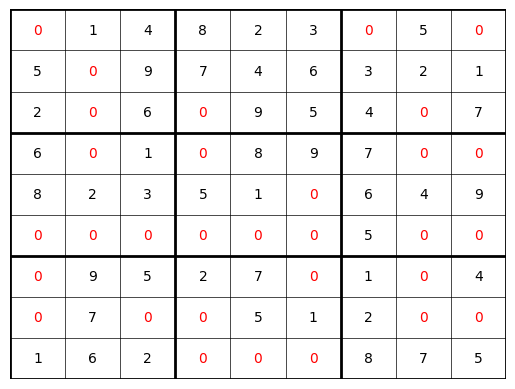

In [171]:
population_size = 200
generations = 1000 
mutation_rate = 0.25
cloning_rate = 0.1
unfill_rate = 0.4

# Use 1
# sudoku = generate_valid_sudoku()
# sudoku = unfill_sudoku(sudoku, unfill_rate)
# Use 2
# Comment this line if you already have a csv file
sudoku_to_csv(unfill_rate)
sudoku = read_sudoku_from_csv()
plot_sudoku(sudoku)

## Genetic algorithm functions
### Note: The use of numba and jit was meant to accelarate the process using a GPU

In [172]:
# Genetic algorithm function to solve a sudoku
def genetic_algorithm(sudoku, population_size, generations, mutation_rate, cloning_rate):
    '''
    Genetic algorithm to solve a sudoku 
    First we generate a population of individuals, each individual is a list of 9 lists, each list contains unfilled values of a row of the sudoku
    Then we evaluate the fitness of each individual
    Then we select the best individuals to reproduce
    Then we reproduce the individuals
    Then we mutate the individuals
    In the end we repeat the process until we reach the number of generations
    and we return the best individual
    '''
    # Generate the population, as well as arrays to keep sotred the best individual and its fitness for each generation
    population = initialize_population(sudoku, population_size)
    fitness = np.zeros(population_size)
    best_fitness = []
    best_individual = []
    # Prefill the values for the first generation
    for _ in range(population_size):
        fitness[_] = fitness_function(population[_], sudoku)
    # Iterate over the generations
    for i in range(generations):
        # Create the new population arrays
        fitness_children = np.zeros(population_size)
        children = []
        # Select the best individual over the population
        bests = 1
        idx = np.argpartition(fitness, -bests)[-bests:]
        best_individual.append(population[idx[0]])
        best_fitness.append(fitness[idx[0]])
        for j, k in enumerate(idx):
            fitness_children[j] = fitness[k]
            children.append(population[k])
        # If the best individual is valid, return it
        if check_if_solved(fill_sudoku(population[idx[0]], sudoku)):
            print('Solved')
            break
        # Print the best individual of the generation
        clear_output(wait=True)
        print('Generation', i, ' - Population size ', population_size,' - Individual fitness:', fitness[idx[0]])
        # Traverse the population and generate the children 
        for j in range(bests, population_size):
            # Select the parents
            parent1 = population[tournament_selection(fitness.copy(), 5)]
            if np.random.random() < cloning_rate:
                # Clone the best individual
                child = parent1.copy()
            else:
                parent2 = population[tournament_selection(fitness.copy(), 5)]
                # Crossover the parents
                child = crossover(parent1.copy(), parent2.copy())
            # Mutate the child
            child = mutate(child, mutation_rate)
            # Add the child to the new population
            children.append(child)
            fitness_children[j] = fitness_function(child, sudoku)
        # Replace the old population with the new one
        fitness = fitness_children.copy()
        population = children.copy()
    # Return the best individual and its fitness over the generations
    return best_fitness, best_individual

@jit(target_backend='cuda') 
def tournament_selection(fitness, tournament_size):
    '''
    Select the best individual over a tournament
    '''
    # Create a random list to store the indexes of the individuals in the tournament
    idx = np.random.randint(0, len(fitness), tournament_size)
    # Return the index of the best individual
    return idx[np.argmax(fitness[idx])]

@jit(target_backend='cuda') 
def crossover(parent1, parent2):
    '''
    Crossover the parents
    '''
    child = []
    for i in range(len(parent1)):
        # Randomly select the parent attributes
        if np.random.random() < 0.5:
            child.append(parent1[i])
        else:
            child.append(parent2[i])
    return np.array(child, dtype=object)

@jit(target_backend='cuda') 
def mutate(individual, mutation_rate):
    '''
    Mutate the individual
    '''
    individual = individual.copy()
    # If the mutation rate is higher than a random number, create a new random individual
    if np.random.random() < mutation_rate:
        return initialize_random_solution(sudoku)
    for row in range(len(individual)):
        # If the mutation rate is higher than a random number, mutate the row with a new random row
        if np.random.random() < mutation_rate:
            individual[row] = np.random.permutation(individual[row])
    return individual

@jit(target_backend='cuda') 
def initialize_population(sudoku, population_size):
    '''
    Initialize the population with random individuals
    '''
    population = []
    for i in range(population_size):
        population.append(initialize_random_solution(sudoku))
    return np.array(population, dtype=object)
 
@jit(target_backend='cuda') 
def initialize_random_solution(sudoku):
    '''
    Initialize a random individual
    '''
    st = set(np.arange(1, 10))
    solution = []
    for i in range(sudoku.shape[0]):
        # Create a list of the values that are not in the sudoku
        numbers = set(sudoku[i])
        missing_numbers = st - numbers
        missing_numbers = list(missing_numbers)
        np.random.shuffle(missing_numbers)
        solution.append(missing_numbers)
    return np.array(solution)

@jit(target_backend='cuda') 
def fill_sudoku(individual, sudoku):
    '''
    Fill the sudoku with the individual
    '''
    filled_sudoku = sudoku.copy()
    for i in range(9):
        idx = 0
        ls = individual[i]
        # Traverse the row and fill the unfilled values
        for j in range(9):
            if filled_sudoku[i, j] == 0:
                filled_sudoku[i, j] = ls[idx]
                idx += 1
    return filled_sudoku

@jit(target_backend='cuda') 
def fitness_function(individual, sudoku):
    '''
    Fitness function to evaluate the individual
    The fitness is defined as the sum of unique values in each row, column and box
    The higher the fitness, the better the individual
    '''
    fitness = 0
    filled_sudoku = fill_sudoku(individual, sudoku)
    # Traverse the sudoku and calculate the fitness for each row & column
    for i in range(9):
        row = filled_sudoku[i, :]
        column = filled_sudoku[:, i]
        row_values = np.unique(row)
        column_values = np.unique(column)
        fitness += len(row_values) + len(column_values)
    # Traverse the sudoku and calculate the fitness for each square
    for k in range(3):
        for l in range(3):
            block = filled_sudoku[3*k:3*k+3, 3*l:3*l+3]
            block_values = np.unique(block)
            fitness += len(block_values)
    return fitness

## General run and results

Generation 47  - Population size  200  - Individual fitness: 241.0
Solved
Solved: True  - Generation: 49
Maximum possible fitness:  243
Fitness of best individual:  243.0


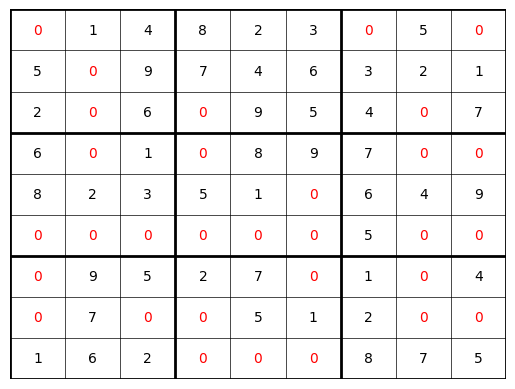

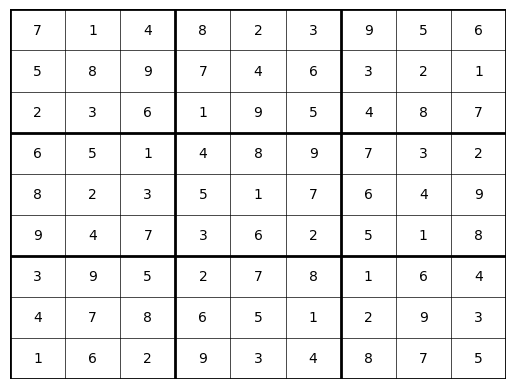

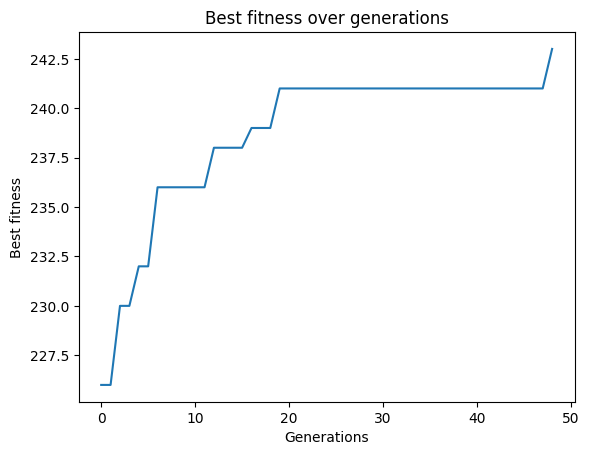

In [173]:
best_fitness, best_individual = genetic_algorithm(sudoku, population_size, generations, mutation_rate, cloning_rate)
best_sudoku = fill_sudoku(best_individual[-1], sudoku)
solved = check_if_solved(best_sudoku)
print('Solved:', solved, ' - Generation:', len(best_fitness))
print('Maximum possible fitness: ', 243)
print('Fitness of best individual: ', best_fitness[-1])
plot_sudoku(sudoku)
plot_sudoku(best_sudoku)
plt.plot(best_fitness)
plt.xlabel('Generations')
plt.ylabel('Best fitness')
plt.title('Best fitness over generations')
plt.show()